### Members' Full name:

Nguyen Mai Dinh, Le - 300312139
Ruiz, Ricardo - 300387021

### References:
- CSIS 3400 – 070: Natural Language Processing CRN 17613 Lab 2 – Natural Language Processing & Text Classification
- CSIS 3400 – 070: Natural Language Processing CRN 17613 Lab 3 – Text Representation Lab 3 
- CSIS 3290 Introduction to Machine Learning Courseworks

# Part A. Planning (Demi)

# Part B. Basic Model

## Imported Libraries

In [85]:
### Import any necessary libraries here

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import itertools


import warnings
warnings.filterwarnings('ignore')

# Download NLTK resources
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ridor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Data exploration, pre-processing and cleansing (Jimmy)

### 1. Load Datasets

In [58]:
# Load the training and test datasets
train_data = pd.read_csv('climate_train.csv')
test_data = pd.read_csv('climate_test.csv')

# Display basic information about the datasets
print("Training data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Training data shape: (1000, 3)
Test data shape: (320, 3)


Training data preview:


,Unnamed: 0,text,label
0,0,− Scope 3: Optional scope that includes indire...,0
1,1,The Group is not aware of any noise pollution ...,0
2,2,Global climate change could exacerbate certain...,0
3,3,Setting an investment horizon is part and parc...,1
4,4,Climate change the physical impacts of climate...,0



Missing values in training data:
Unnamed: 0    0
text          0
label         0
dtype: int64

Data types in training data:
Unnamed: 0     int64
text          object
label          int64
dtype: object


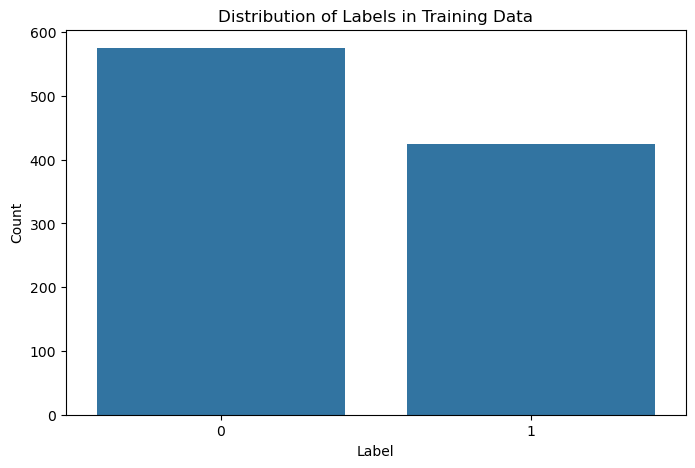

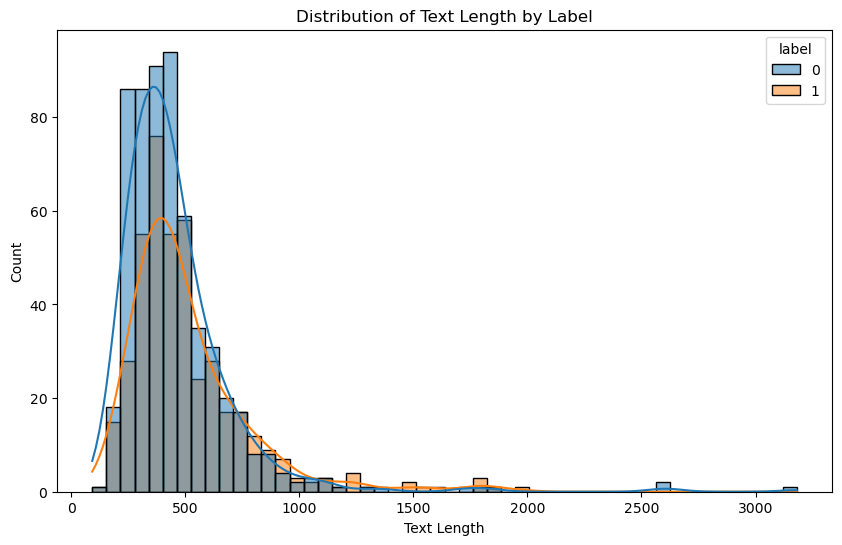


Example texts for each label:

Label 0 example:
− Scope 3: Optional scope that includes indirect emissions associated with the goods and services supply chain produced outside the organization. Included are emissions from the transport of products from our logistics centres to stores (downstream) performed by external logistics operators (air, land and sea transport) as well as the emissions associated with electricity consumption in franchise stores.

Label 1 example:
Setting an investment horizon is part and parcel of our policy of focusing on the long term and helping clients to build capital. Both financial and non-financial aspects play a role in measuring investment returns. Even if we make a successful investment in a mining company today, the same company may nonetheless cause damage to the environment tomorrow, and thus be compelled to make substantial provisions for improving its waste-processing activities and paying fines. As an asset manager that focuses on the long-term 

In [59]:
# Display the first few rows of the training data
print("Training data preview:")
display(train_data.head())

# Check for missing values
print("\nMissing values in training data:")
print(train_data.isnull().sum())

# Check data types
print("\nData types in training data:")
print(train_data.dtypes)

# Explore the distribution of labels in the training set
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=train_data)
plt.title('Distribution of Labels in Training Data')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Explore text length distribution
train_data['text_length'] = train_data['text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data=train_data, x='text_length', hue='label', bins=50, kde=True)
plt.title('Distribution of Text Length by Label')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

# Display some example texts for each label
print("\nExample texts for each label:")
for label in train_data['label'].unique():
    print(f"\nLabel {label} example:")
    print(train_data[train_data['label'] == label]['text'].iloc[0])

Example texts for each label:

Label 0 example:
− Scope 3: Optional scope that includes indirect emissions associated with the goods and services supply chain produced outside the organization. Included are emissions from the transport of products from our logistics centres to stores (downstream) performed by external logistics operators (air, land and sea transport) as well as the emissions associated with electricity consumption in franchise stores.

Label 1 example:
Setting an investment horizon is part and parcel of our policy of focusing on the long term and helping clients to build capital. Both financial and non-financial aspects play a role in measuring investment returns. Even if we make a successful investment in a mining company today, the same company may nonetheless cause damage to the environment tomorrow, and thus be compelled to make substantial provisions for improving its waste-processing activities and paying fines. As an asset manager that focuses on the long-term prospects, we can’t ignore the non-financial aspects.

### 2. Data Pre-processing and Cleansing

We clean and prepare our text data for analysis. Text data often contains noise such as punctuation, numbers, and common words (stopwords) that don't contribute much to the meaning. We'll remove these elements to improve the quality of our features.

#### 2.1 Text Cleaning Function
We define a comprehensive text cleaning function that performs several important preprocessing steps.¶

In [60]:
# Define a function to clean the text
def clean_text(text):
    # Convert to lowercase for consistency
    text = text.lower()
    
    # Remove digits as they typically don't add meaning in climate text analysis
    text = re.sub(r'\d+', '', text)
    
    # Remove punctuation marks
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize the text into individual words
    tokens = word_tokenize(text)
    
    # Remove stopwords (common words like 'the', 'and', 'is')
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Join tokens back into text
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

### **2.2 Applying Text Cleaning**

Now we'll apply our cleaning function to both the training and test datasets.

In [61]:
# Apply the cleaning function to both datasets
train_data['cleaned_text'] = train_data['text'].apply(clean_text)
test_data['cleaned_text'] = test_data['text'].apply(clean_text)

# Display examples of original and cleaned text
print("Original vs Cleaned Text Examples:")
for i in range(3):
    print(f"\nOriginal: {train_data['text'].iloc[i][:100]}...")
    print(f"Cleaned: {train_data['cleaned_text'].iloc[i][:100]}...")

Original vs Cleaned Text Examples:

Original: − Scope 3: Optional scope that includes indirect emissions associated with the goods and services su...
Cleaned: scope optional scope includes indirect emissions associated goods services supply chain produced out...

Original: The Group is not aware of any noise pollution that could negatively impact the environment, nor is i...
Cleaned: group aware noise pollution could negatively impact environment aware impact biodiversity regards la...

Original: Global climate change could exacerbate certain of the threats facing our business, including the fre...
Cleaned: global climate change could exacerbate certain threats facing business including frequency severity ...


#### **2.3 Analyzing Text Cleaning Results**
We visualize how our cleaning process has affected the text data.


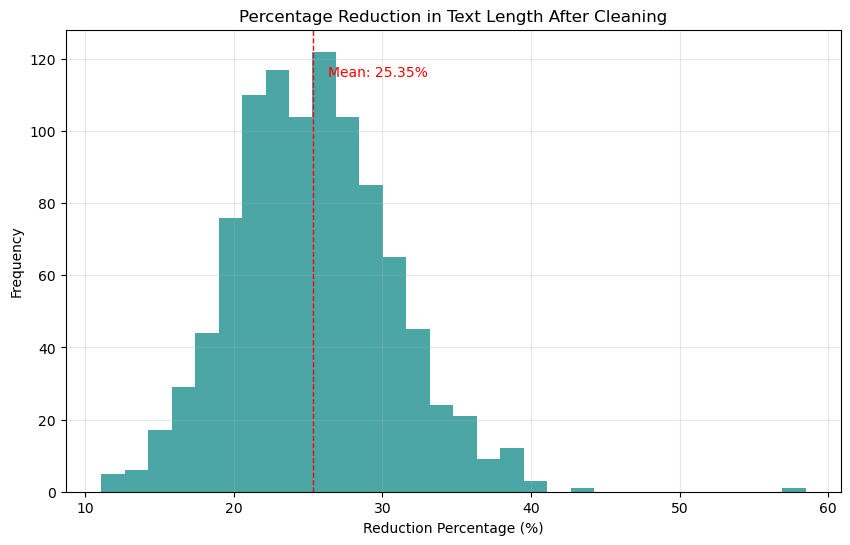

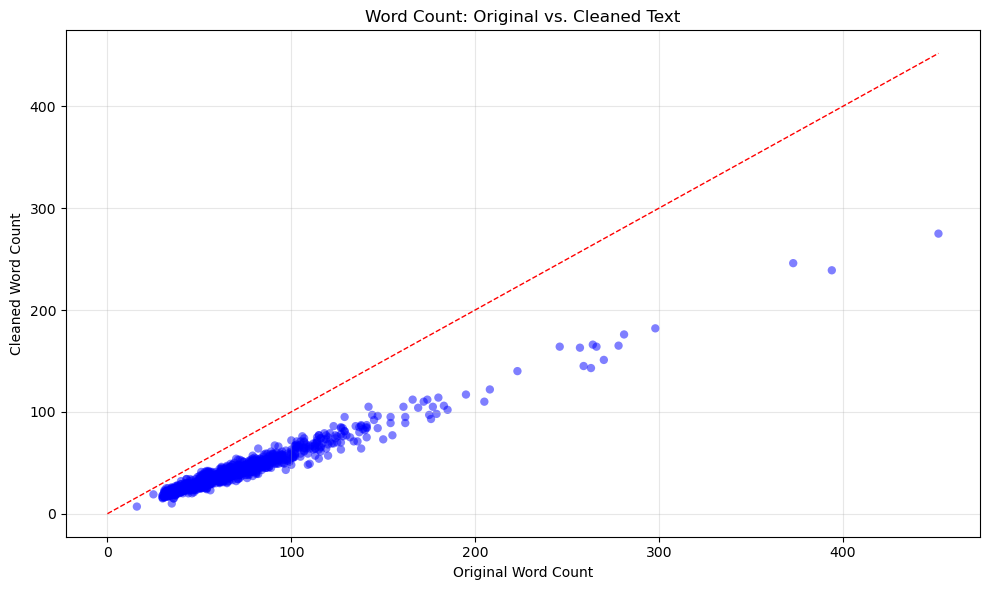

Text Cleaning Summary Statistics:


,Metric,Value
0,Original Mean Length,479.103000
1,Cleaned Mean Length,358.763000
2,Mean Length Reduction,120.340000
3,Mean Reduction Percentage,25.348503
4,Original Mean Word Count,72.224000
5,Cleaned Mean Word Count,43.277000


In [62]:
# Calculate text length before and after cleaning
train_data['original_length'] = train_data['text'].apply(len)
train_data['cleaned_length'] = train_data['cleaned_text'].apply(len)
train_data['length_reduction'] = train_data['original_length'] - train_data['cleaned_length']
train_data['reduction_percentage'] = (train_data['length_reduction'] / train_data['original_length']) * 100

# Create a histogram of text length reduction
plt.figure(figsize=(10, 6))
plt.hist(train_data['reduction_percentage'], bins=30, color='teal', alpha=0.7)
plt.axvline(train_data['reduction_percentage'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.text(train_data['reduction_percentage'].mean()+1, plt.ylim()[1]*0.9, 
         f'Mean: {train_data["reduction_percentage"].mean():.2f}%', color='red')
plt.title('Percentage Reduction in Text Length After Cleaning')
plt.xlabel('Reduction Percentage (%)')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

# Compare word counts before and after cleaning
train_data['original_word_count'] = train_data['text'].apply(lambda x: len(str(x).split()))
train_data['cleaned_word_count'] = train_data['cleaned_text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
plt.scatter(train_data['original_word_count'], train_data['cleaned_word_count'], 
           alpha=0.5, color='blue', edgecolors='none')
plt.plot([0, train_data['original_word_count'].max()], [0, train_data['original_word_count'].max()], 
         'r--', linewidth=1)
plt.title('Word Count: Original vs. Cleaned Text')
plt.xlabel('Original Word Count')
plt.ylabel('Cleaned Word Count')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Display summary statistics of text cleaning
cleaning_stats = pd.DataFrame({
    'Metric': ['Original Mean Length', 'Cleaned Mean Length', 'Mean Length Reduction', 
               'Mean Reduction Percentage', 'Original Mean Word Count', 'Cleaned Mean Word Count'],
    'Value': [train_data['original_length'].mean(), 
              train_data['cleaned_length'].mean(),
              train_data['length_reduction'].mean(),
              train_data['reduction_percentage'].mean(),
              train_data['original_word_count'].mean(),
              train_data['cleaned_word_count'].mean()]
})

print("Text Cleaning Summary Statistics:")
display(cleaning_stats)

In [63]:
#The text cleaning process has successfully removed noise 
#from our data while preserving the meaningful content. 
#As shown in the visualizations, we've reduced the text length by 
#removing stopwords, punctuation, and digits, which will help our model 
#focus on the most informative words related to climate topics.

## Feature generation with TF-IDF (Jimmy)

we converted our cleaned text data into numerical features that machine learning algorithms can process. We'll use the Term Frequency-Inverse Document Frequency (TF-IDF) technique, which is particularly effective for text classification tasks.


#### **3.1 Understanding TF-IDF**

TF-IDF helps us identify words that are important to a document in a collection. It weighs down common words that appear across many documents while giving importance to words that are unique to specific documents. This makes it ideal for identifying distinctive vocabulary related to climate topics.

#### **3.2 Creating TF-IDF Features**

Implementing the TF-IDF vectorization:

In [64]:
# Initialize the TF-IDF vectorizer with a limit of 5000 features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit the vectorizer on the training data only to avoid data leakage
tfidf_vectorizer.fit(train_data['cleaned_text'])

# Transform both training and test data into TF-IDF feature matrices
X_train_tfidf = tfidf_vectorizer.transform(train_data['cleaned_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_data['cleaned_text'])

# Get the target variable for training
y_train = train_data['label']

# Display the shape of the feature matrices
print("Training features shape:", X_train_tfidf.shape)
print("Test features shape:", X_test_tfidf.shape)

Training features shape: (1000, 5000)
Test features shape: (320, 5000)


#### **3.3 Analyzing TF-IDF Features**

We examine the most common and most unique words in our dataset based on their IDF scores.

In [65]:
# Display the top features (words) based on their IDF scores
feature_names = tfidf_vectorizer.get_feature_names_out()
idf_values = tfidf_vectorizer.idf_
feature_idf = dict(zip(feature_names, idf_values))
sorted_features = sorted(feature_idf.items(), key=lambda x: x[1])

print("\nTop 20 most common words (lowest IDF):")
for word, idf in sorted_features[:20]:
    print(f"{word}: {idf}")

print("\nTop 20 most unique words (highest IDF):")
for word, idf in sorted_features[-20:]:
    print(f"{word}: {idf}")


Top 20 most common words (lowest IDF):
climate: 1.9712185742327941
change: 2.317767798804364
energy: 2.43229122738371
emissions: 2.483804761833818
also: 2.552168504643208
risks: 2.561647248597752
risk: 2.5906347854710043
carbon: 2.6564813512685905
business: 2.693819021706235
environmental: 2.7047480922384253
impact: 2.815004578508458
financial: 2.9671123567059166
gas: 3.02595285672885
new: 3.02595285672885
investment: 3.064567692856629
may: 3.104733734581964
million: 3.104733734581964
group: 3.1296312862036912
transition: 3.1296312862036912
including: 3.1465808445174646

Top 20 most unique words (highest IDF):
unacceptable: 7.215607598755275
updating: 7.215607598755275
upton: 7.215607598755275
uspp: 7.215607598755275
valley: 7.215607598755275
vancity: 7.215607598755275
var: 7.215607598755275
vesting: 7.215607598755275
vicsuper: 7.215607598755275
votes: 7.215607598755275
wba: 7.215607598755275
wealthify: 7.215607598755275
whr: 7.215607598755275
wte: 7.215607598755275
yen: 7.21560759875

#### **3.4 Visualizing TF-IDF Insights**

We created visualizations to better understand our TF-IDF features.

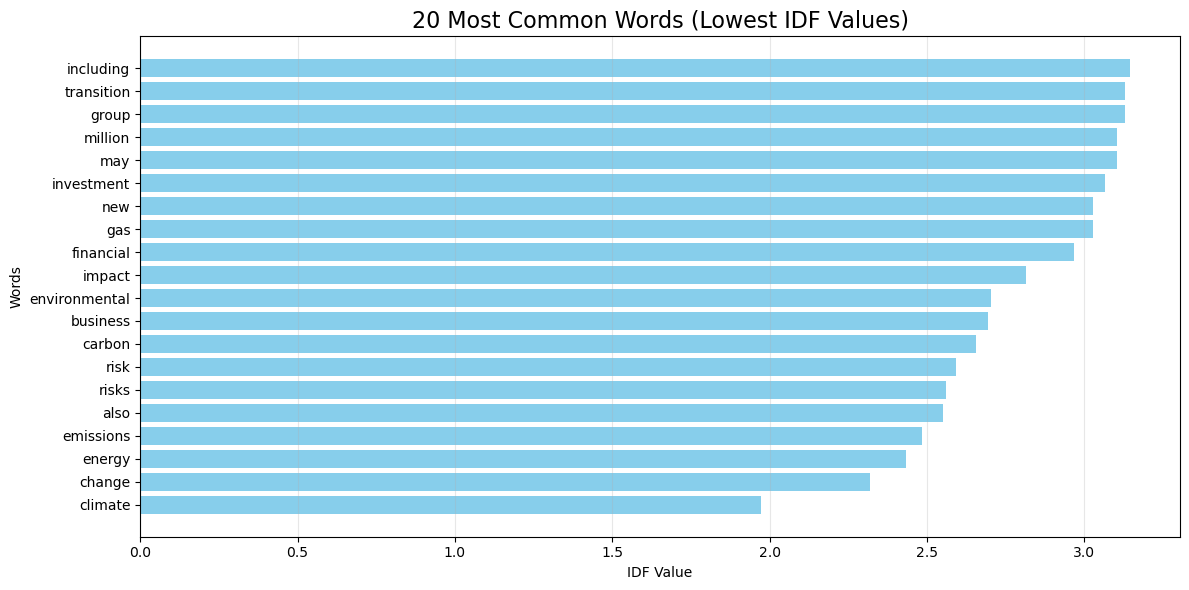

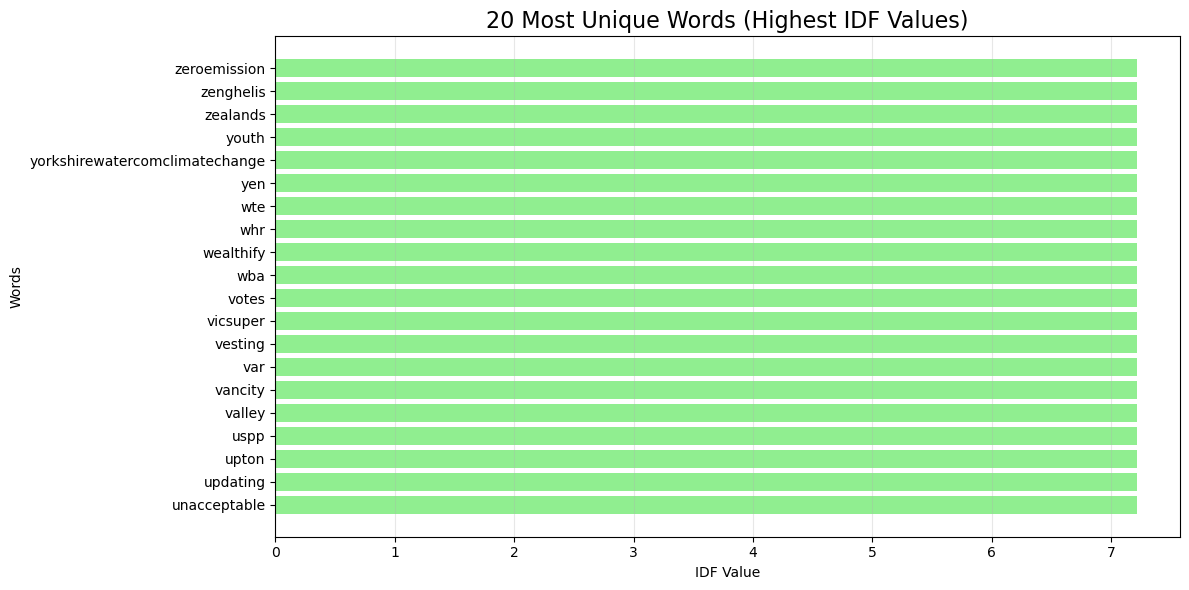

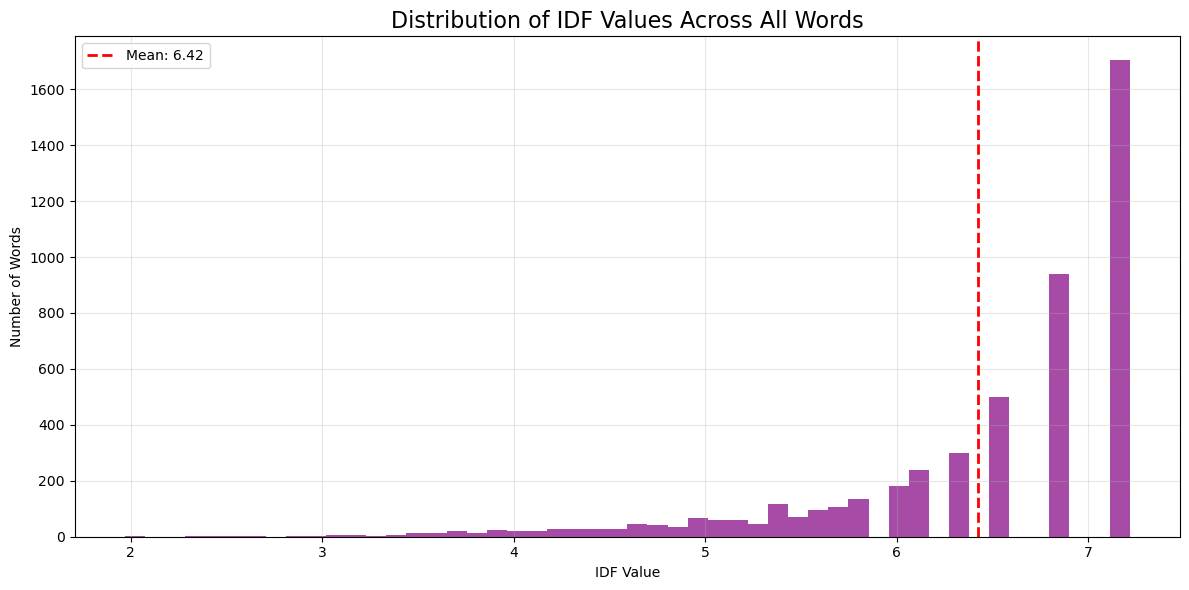

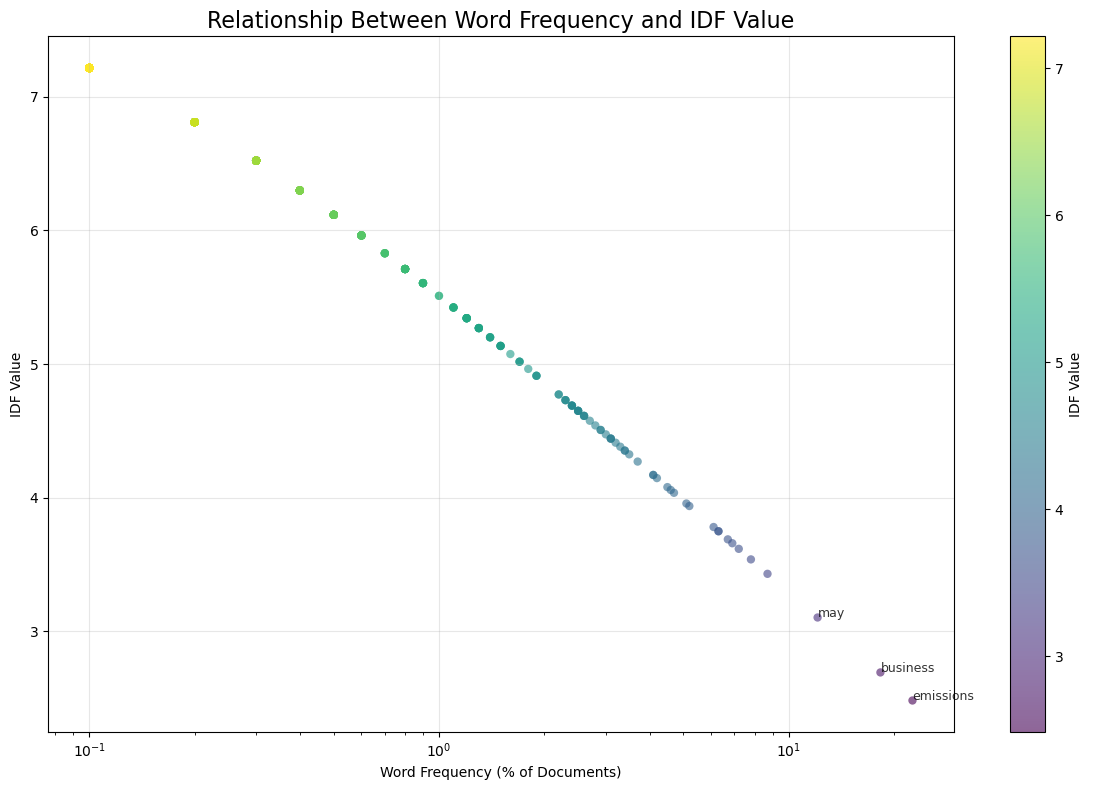

In [66]:
# Visualization 1: Bar chart of most common words
plt.figure(figsize=(12, 6))
common_words = [word for word, _ in sorted_features[:20]]
common_idf = [idf for _, idf in sorted_features[:20]]
plt.barh(common_words, common_idf, color='skyblue')
plt.title('20 Most Common Words (Lowest IDF Values)', fontsize=16)
plt.xlabel('IDF Value')
plt.ylabel('Words')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Visualization 2: Bar chart of most unique words
plt.figure(figsize=(12, 6))
unique_words = [word for word, _ in sorted_features[-20:]]
unique_idf = [idf for _, idf in sorted_features[-20:]]
plt.barh(unique_words, unique_idf, color='lightgreen')
plt.title('20 Most Unique Words (Highest IDF Values)', fontsize=16)
plt.xlabel('IDF Value')
plt.ylabel('Words')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Visualization 3: Distribution of IDF values
plt.figure(figsize=(12, 6))
plt.hist(idf_values, bins=50, color='purple', alpha=0.7)
plt.title('Distribution of IDF Values Across All Words', fontsize=16)
plt.xlabel('IDF Value')
plt.ylabel('Number of Words')
plt.grid(alpha=0.3)
plt.axvline(np.mean(idf_values), color='red', linestyle='dashed', 
           linewidth=2, label=f'Mean: {np.mean(idf_values):.2f}')
plt.legend()
plt.tight_layout()
plt.show()

# Visualization 4: Scatter plot of word frequency vs IDF
# Calculate document frequency for each word
word_freq = {}
for word in feature_names:
    word_freq[word] = sum(1 for doc in train_data['cleaned_text'] if word in doc.split())

# Convert to percentage
total_docs = len(train_data)
word_freq_pct = {word: (freq/total_docs)*100 for word, freq in word_freq.items()}

# Create lists for plotting
words = list(word_freq_pct.keys())
frequencies = [word_freq_pct[word] for word in words]
idfs = [feature_idf[word] for word in words]

# Sample 500 random words for better visualization
if len(words) > 500:
    indices = np.random.choice(range(len(words)), 500, replace=False)
    sampled_words = [words[i] for i in indices]
    sampled_freq = [frequencies[i] for i in indices]
    sampled_idf = [idfs[i] for i in indices]
else:
    sampled_words = words
    sampled_freq = frequencies
    sampled_idf = idfs

plt.figure(figsize=(12, 8))
scatter = plt.scatter(sampled_freq, sampled_idf, alpha=0.6, c=sampled_idf, 
                     cmap='viridis', edgecolors='none')
plt.colorbar(scatter, label='IDF Value')
plt.title('Relationship Between Word Frequency and IDF Value', fontsize=16)
plt.xlabel('Word Frequency (% of Documents)')
plt.ylabel('IDF Value')
plt.xscale('log')
plt.grid(alpha=0.3)

# Annotate some interesting words
for i, word in enumerate(sampled_words):
    if sampled_freq[i] > 10 or sampled_idf[i] > 8:
        plt.annotate(word, (sampled_freq[i], sampled_idf[i]), 
                    fontsize=9, alpha=0.8)

plt.tight_layout()
plt.show()

#### **Calculating Average TF-IDF Values by Class**

We analyze the most discriminative features for each class based on TF-IDF values. This will help us understand which words are most characteristic of each class. 

First, we calculate the mean TF-IDF value for each feature across documents of the same class.

In [67]:
# Calculate average TF-IDF values for each class
labels = train_data['label'].unique()  # Get unique class labels
class_feature_means = {}  # Dictionary to store mean values

for label in labels:
    # Get indices for this class
    indices = train_data[train_data['label'] == label].index
    
    # Get TF-IDF values for these documents
    class_vectors = X_train_tfidf[indices]
    
    # Calculate mean TF-IDF for each feature
    class_feature_means[label] = np.array(class_vectors.mean(axis=0))[0]

Then we identify the top features (words) that are most characteristic of each class:

In [68]:
# Find top discriminative features for each class
top_n = 15  # Number of top features to extract
class_top_features = {}  # Dictionary to store top features for each class

for label in labels:
    # Get feature importance for this class
    feature_importance = [(feature_names[i], class_feature_means[label][i]) 
                         for i in range(len(feature_names))]
    
    # Sort by importance (highest TF-IDF values first)
    sorted_features = sorted(feature_importance, key=lambda x: x[1], reverse=True)
    
    # Store top features
    class_top_features[label] = sorted_features[:top_n]

Finally, we created bar charts to visualize the most important words for each class.

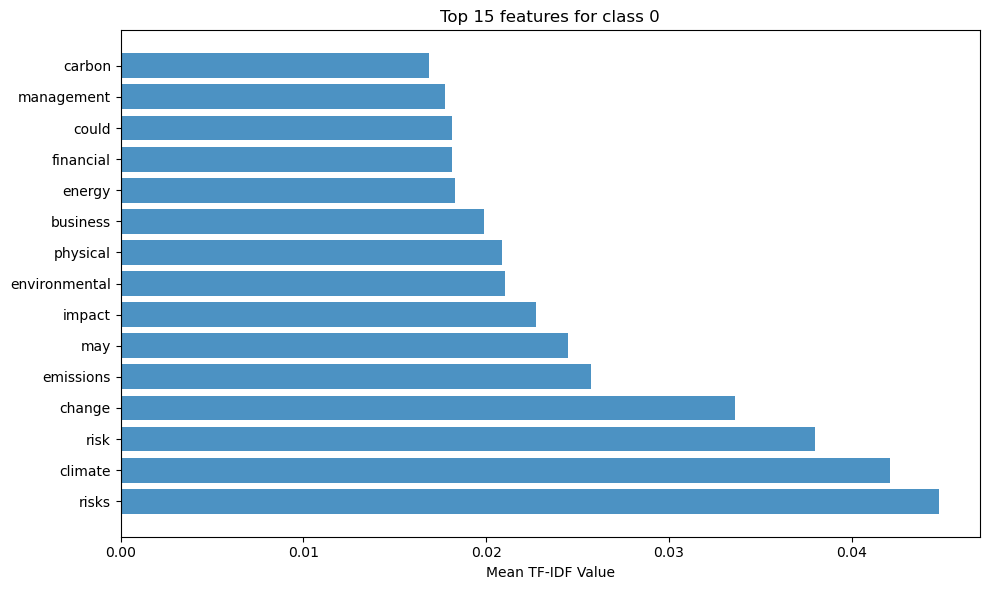

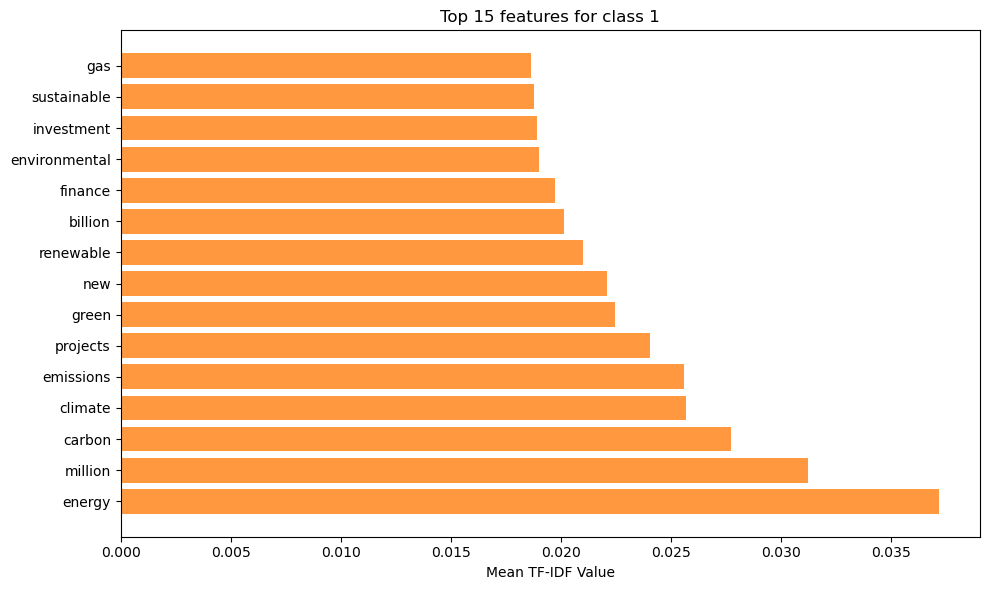

In [69]:
# Visualize top features for each class
for label in labels:
    plt.figure(figsize=(10, 6))  # Set figure size
    words = [word for word, _ in class_top_features[label]]  # Extract words
    values = [value for _, value in class_top_features[label]]  # Extract TF-IDF values
    
    plt.barh(words, values, color=f'C{label}', alpha=0.8)  # Create horizontal bar chart
    plt.title(f'Top {top_n} features for class {label}')  # Add title
    plt.xlabel('Mean TF-IDF Value')  # Label x-axis
    plt.tight_layout()  # Adjust layout
    plt.show()  # Display the chart

In [70]:
#These visualizations will help us understand which words are most strongly associated 
#with each class in our dataset, providing insights into the distinguishing 
#characteristics of each category.

### Naive Bayes Model Building (Ricardo)

**Goal:** Train a Multinomial Naive Bayes classifier using the TF‑IDF features created above.

In [71]:
X_train = train_data["cleaned_text"]
X_test  = test_data["cleaned_text"]

y_train = train_data["label"]
y_test  = test_data["label"]

In [72]:
nb = MultinomialNB(alpha=1.0) 
nb.fit(X_train_tfidf, y_train)

print("model training finished") 

model training finished


### Model Testing & Evaluation (Ricardo)

In [86]:

def evaluate_model(y_true, y_pred, y_proba=None):
    """Print standard classification metrics.
    y_proba should be the probability of the positive class (binary only).
    """
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average='weighted')
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec  = recall_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f'Accuracy : {acc:.4f}')
    print(f'F1 (w)   : {f1:.4f}')
    print(f'Precision: {prec:.4f}')
    print(f'Recall   : {rec:.4f}')
    print('\nClassification report:\n', classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    print('Confusion matrix:\n', cm)

    # ROC-AUC (binary only)
    if y_proba is not None:
        try:
            auc = roc_auc_score(y_true, y_proba)
            print(f'ROC AUC  : {auc:.4f}')
        except Exception as e:
            print('ROC AUC not computed. Reason:', str(e))

    return {'accuracy': acc, 'f1_weighted': f1, 'precision_weighted': prec, 'recall_weighted': rec}


In [87]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black"
        )

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Accuracy : 0.7875
F1 (w)   : 0.7826
Precision: 0.7810
Recall   : 0.7875

Classification report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85       222
           1       0.68      0.58      0.63        98

    accuracy                           0.79       320
   macro avg       0.75      0.73      0.74       320
weighted avg       0.78      0.79      0.78       320

Confusion matrix:
 [[195  27]
 [ 41  57]]
ROC AUC  : 0.8374


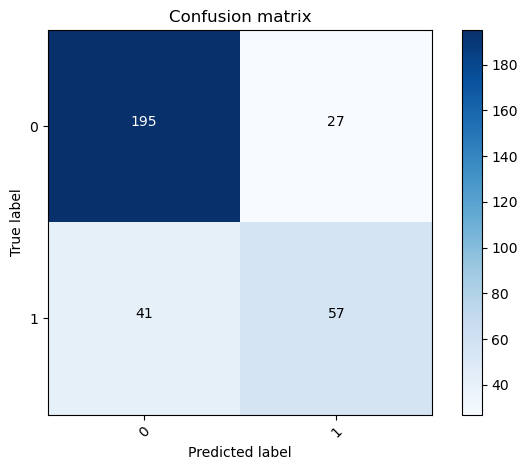

In [91]:
# Testing phase: create y_test, predict on X_test_tfidf, and evaluate

y_test = test_data['label']

# Predict class labels for the test set
y_pred = nb.predict(X_test_tfidf)

# Predict probabilities (binary only). For multiclass, skip ROC-AUC in this baseline.
y_proba = None
if hasattr(nb, 'predict_proba') and len(nb.classes_) == 2:
    # sklearn returns probabilities in the same order as nb_baseline.classes_
    # We take the probability of the 'second' class (often the positive class).
    y_proba = nb.predict_proba(X_test_tfidf)[:, 1]

metrics = evaluate_model(y_test, y_pred, y_proba=y_proba);


conf_mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat, classes=['0', '1'])
plt.show()



## 5) Testing & Evaluation — What the numbers mean

Overall, the metrics indicate a **solid baseline**: the model generalizes reasonably well to the test set (good overall discrimination), but performance is **uneven across the two classes**.

### What the metrics imply
- **Accuracy / weighted F1**: The model is correct most of the time and its average performance is decent, mostly because it performs well on the majority class.
- **Macro average**: Lower than the weighted scores, which signals the model is **less balanced** across class 0 and class 1.
- **ROC AUC**: Shows the model can **separate class 0 vs class 1** fairly well overall, even if the final class decisions still produce some errors.

### Confusion matrix insight (error types)
- **FN (false negatives) are the main weakness:** predicted **class 0** when the true label is **class 1**.  
  This directly explains the **lower recall for class 1**: the model misses a noticeable portion of class 1 cases.

### Practical takeaway
The classifier is **more reliable at identifying class 0** than capturing all class 1 cases. If class 1 is the priority, improvements should focus on **reducing false negatives** (better features like n-grams, class balancing, or a stronger linear model in Part C).


## Post analysis: most impactful features (tokens)

### Why we do post-analysis
After training a **Multinomial Naïve Bayes (MNB)** text classifier, it is important to interpret *why* the model predicts a statement **Class 1** vs **Class 0**. In MNB, each token contributes to the final decision through its conditional probability given a class. This post-analysis helps us (1) validate that the model learned meaningful language patterns, and (2) identify how the model could be improved (e.g., by adding n-grams or adjusting preprocessing).

- It is used Naive Bayes feature probabilities (model-based): MultinomialNB stores `feature_log_prob_`,
   which indicates how strongly each token is associated with each class. 


In [92]:
# Feature names come from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()
classes = nb.classes_

# feature_log_prob_[c, j] = log P(feature_j | class_c)
log_probs = nb.feature_log_prob_

top_n = 20

print('Top tokens per class (highest log-probability):')
for ci, cls in enumerate(classes):
    top_idx = np.argsort(log_probs[ci])[::-1][:top_n]
    print(f'\nClass {cls}:')
    for j in top_idx:
        print(f'  {feature_names[j]}')

# If binary, also show the most discriminative tokens between the two classes
if len(classes) == 2:
    diff = log_probs[1] - log_probs[0]  # positive means stronger for class 1
    top_for_class1 = np.argsort(diff)[::-1][:top_n]
    top_for_class0 = np.argsort(diff)[:top_n]

    print('\nMost discriminative tokens (binary):')
    print(f'\nTokens pushing toward class {classes[1]}:')
    for j in top_for_class1:
        print(f'  {feature_names[j]}  (diff={diff[j]:.3f})')

    print(f'\nTokens pushing toward class {classes[0]}:')
    for j in top_for_class0:
        print(f'  {feature_names[j]}  (diff={diff[j]:.3f})')


Top tokens per class (highest log-probability):

Class 0:
  risks
  climate
  risk
  change
  emissions
  may
  impact
  environmental
  physical
  business
  energy
  financial
  could
  management
  carbon
  impacts
  transition
  also
  weather
  group

Class 1:
  energy
  million
  carbon
  climate
  emissions
  projects
  green
  new
  renewable
  billion
  finance
  environmental
  investment
  sustainable
  gas
  also
  companies
  fund
  power
  target

Most discriminative tokens (binary):

Tokens pushing toward class 1:
  million  (diff=1.950)
  solar  (diff=1.901)
  committed  (diff=1.838)
  green  (diff=1.637)
  ifc  (diff=1.461)
  billion  (diff=1.453)
  fund  (diff=1.422)
  target  (diff=1.403)
  announced  (diff=1.385)
  mw  (diff=1.363)
  invested  (diff=1.312)
  bonds  (diff=1.297)
  commitment  (diff=1.294)
  invest  (diff=1.294)
  finance  (diff=1.289)
  projects  (diff=1.144)
  bond  (diff=1.132)
  principles  (diff=1.084)
  goal  (diff=1.078)
  pledged  (diff=1.072)


## What the model learned

### Interpretation per class (meaning of Class 0 vs Class 1)
- **Class 0** is dominated by *risk framing* and *uncertainty language*: words like **physical, weather, extreme, flooding, losses, damage, could, may**.  
  This suggests Class 0 statements often describe **exposure and potential impacts** (physical climate risk, cost/reputation impact) rather than describing concrete action.

- **Class 1** is dominated by *action and implementation signals*: words like **projects, renewable, solar, invested/investment, fund, bonds, committed/pledged, target/goal**, plus **scale/measurement language** (**million, billion, mw**).  
  This suggests Class 1 statements are recognized as climate action when they mention **initiatives, financing, commitments, targets, and measurable scale**.

### What this tells us about the dataset and model behavior
1. **Shared vocabulary is normal:** Words like *climate, carbon, emissions, energy* appear in both classes, meaning they are not enough by themselves to classify relevance.  
2. **Action vs. Risk is the main separation:**  
   - Class 1 tokens capture *investments, targets, projects, and measurable scale (million/billion, MW).*  
   - Class 0 tokens capture *physical risks, uncertainty language, and potential losses.*
3. **Model seems conceptually aligned with the task:** The discriminative tokens match what humans would consider “climate action” (commitments, investments, projects) versus “climate risk discussion” (physical risks, possible damage).

### Limitations of this analysis
- Naïve Bayes assumes token independence, so interpretation is **token-level**, not phrase-level.  
- Some tokens (e.g., *million, billion*) may reflect **writing style** (quantified reports) rather than genuine action content.
- Unigrams miss phrases like **“net zero,” “science-based targets,” “renewable energy,”** which are often important indicators.

### Improvement ideas motivated by post-analysis
1. **Add bigrams (n-grams):** use `ngram_range=(1,2)` in TF-IDF to capture phrases like *net zero*, *renewable energy*, *green bonds*.  
2. **Tune TF-IDF filtering:** set `min_df` and `max_df` to reduce noise and overly common tokens.  
3. **Try ComplementNB:** often performs better than MultinomialNB on TF-IDF text classification.  
4. **Try a linear model (Part C direction):** Logistic Regression or Linear SVM can better use discriminative TF-IDF weights.  
5. **Error-driven refinement:** since Class 1 recall is typically harder, adjust model settings or class weighting in later models to reduce false negatives for action statements.


# Part C. Comparison with other models

### Classifier Comparison (Hugh)

### Feature generation comparison (Demi)